/Users/qiutan/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


closest distance between (4.003174603174614, 0.9936507936507968) and (array([2.64011371]), array([5.17823434])): 4.400985625203996
closest distance between (4.296449218910173, 1.2331706917052796) and (array([2.9197327]), array([5.27144474])): 4.266498059975854
closest distance between (4.613314680636021, 1.443754828321644) and (array([3.21190393]), array([5.37335761])): 4.172017513473085
closest distance between (4.9518347784943435, 1.6267129925213506) and (array([3.51494153]), array([5.48385666])): 4.116092745903226
closest distance between (5.310073302627328, 1.783354973325864) and (array([3.82780052]), array([5.60286997])): 4.097051062113875
closest distance between (5.686094043177158, 1.9149905597566443) and (array([4.14955271]), array([5.73014173])): 4.11294757040307
closest distance between (6.077960790286021, 2.0229295408351553) and (array([4.48085768]), array([5.86577092])): 4.161510328354839
closest distance between (6.483737334096105, 2.108481705582859) and (array([4.82318147

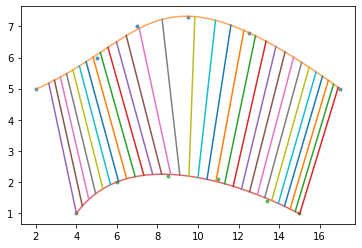

In [10]:
import numpy as np
import scipy.interpolate
import scipy.optimize
import matplotlib.pyplot as plt


class UnivariatePolynomial():
    """
    Approximates a curve given a set of x, y coordinates.
    The curve is stored as two univariate polynomials over its length.
    """
    def __init__(self, xs, ys, degree=3):
        if len(xs) != len(ys):
            raise ValueError("xs and ys must have the same length!")
        self.xs = np.array(xs)
        self.ys = np.array(ys)
        self.ls = np.arange(0, len(xs))
        #self.px = scipy.interpolate.CubicSpline(ts, xs)
        #self.py = scipy.interpolate.CubicSpline(ts, ys)
        self.px = np.polynomial.Polynomial.fit(self.ls, xs, degree)
        self.py = np.polynomial.Polynomial.fit(self.ls, ys, degree)
        
        self.pl = np.polynomial.Polynomial.fit(xs, self.ls, degree)

    def eval(self, x):
        """
        NOTE: only an approximation; not precise!
        """
        if x < np.min(self.xs) or np.max(self.xs) < x:
            raise ValueError("Value out of range!")
        l = self.pl(x)
        return self.py(l)

    def divide(self, no_points):
        curve_length = np.max(self.ls)
        division_length = curve_length / (no_points - 1)
        for i in np.arange(0, curve_length, step=division_length):
            yield (self.px(i), self.py(i))
        yield (self.px(curve_length), self.py(curve_length))

    def closest_point(self, point):
        def distance_to_curve(l):
            if l < 0 or np.max(self.ls) < l:
                return np.inf
            x = self.px(l)
            y = self.py(l)
            return np.sqrt((x-point[0])**2 + (y-point[1])**2)
        initial_guess = np.max(self.ls) / 2
        result = scipy.optimize.minimize(
            distance_to_curve, initial_guess, method='Nelder-Mead',
            #bounds=[(np.min(self.xs), np.max(self.xs))]
        )
        if result.success:
            # return (x, y, dist)
            return (self.px(result.x), self.py(result.x)), result.fun
        else:
            raise Exception(
                "Could not find any solution!\n %s" % result.message
            )

    def plot(self, show=True):
        ls = np.arange(0, np.max(self.ls) + 0.1, 0.1)
        plt.plot(self.xs, self.ys, '.', label='Ground Truth', alpha=0.7)
        plt.plot(self.px(ls), self.py(ls), '-', label='Curve', alpha=0.7)
        if show:
            plt.show()
            
"""
    Input here the coordinates of two lines(outer and inner) on border of villi that measured from Fiji
    as described in method section.
    
    Here is an example.
"""

xs_outer = [2, 5, 7, 9.5, 12.5, 17]
ys_outer = [5, 6, 7, 7.3, 6.8, 5]

xs_inner = [4, 6, 8.5, 11, 13.4, 15]
ys_inner = [1, 2, 2.2, 2.1, 1.4, 1]

up_outer = UnivariatePolynomial(xs_outer, ys_outer)
up_inner = UnivariatePolynomial(xs_inner, ys_inner)

up_outer.plot(show=False)
up_inner.plot(show=False)
#plt.show()

for point_inner in up_inner.divide(30):
    point_outer, dist = up_outer.closest_point(point_inner)
    _ = plt.plot(
        [point_inner[0], point_outer[0]],
        [point_inner[1], point_outer[1]],
        '-'
    )
    print(
        "closest distance between %s and %s: %s"
        % (point_inner, point_outer, dist)
    )

plt.show()

